In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

import torchvision.models as models
from tqdm import tqdm

In [4]:
data_dir = '/content/drive/MyDrive/ece285_project/DataSets'
dataset = 'cifar10'





In [89]:
import random
import torch.nn.functional as F


class ZigZag(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self):
        pass
    def __call__(self, sample):
        # image, landmarks = sample['image'], sample['landmarks']
        img = sample
        img = img.reshape(3,2,12,24).transpose(2,3).reshape(3,4,12,12)
        img = img[:,randperm(4),:,:]
        img = img.reshape(3,2,24,12).transpose(2,3).reshape(3,24,24)
        return img

In [90]:
import numpy as np
import torch
from torch import nn
from torchvision.transforms import transforms
from torch import randperm
np.random.seed(0)


class GaussianBlur(object):
    """blur a single image on CPU"""
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img


In [100]:
from torch._C import Size
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
# mSize = Size((3,3 ))
# Data
s = 0.5
color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
transform_train_1 = transforms.Compose([
                                              transforms.RandomResizedCrop(size=Size((24,24))),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomApply([color_jitter], p=0.8),
                                              transforms.RandomGrayscale(p=0.2),
                                              GaussianBlur(kernel_size=4),
                                              transforms.ToTensor(),
                                                ZigZag(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform_train)
trainset1 = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform_train_1)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=data_dir, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


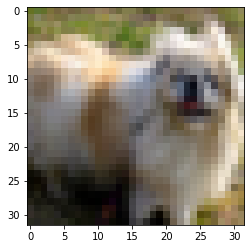

In [101]:
import matplotlib.pyplot as plt
plt.imshow(trainset[40][0].permute(1,2,0))

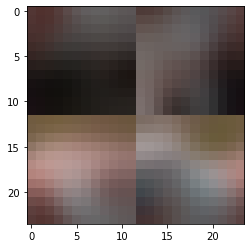

In [103]:
import matplotlib.pyplot as plt
plt.imshow(trainset1[40][0].permute(1,2,0))

In [99]:

a = torch.arange(3*4*4).reshape(3,4,4)
a

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]],

        [[32, 33, 34, 35],
         [36, 37, 38, 39],
         [40, 41, 42, 43],
         [44, 45, 46, 47]]])

In [ ]:
a.reshape(3,2,2,4).transpose(2,3).reshape(3,4,2,2).reshape(3,2,4,2).transpose(2,3).reshape(3,4,4)

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]],

        [[32, 33, 34, 35],
         [36, 37, 38, 39],
         [40, 41, 42, 43],
         [44, 45, 46, 47]]])

In [ ]:
a.shape

torch.Size([3, 32, 32])